# Imports

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch.optim as optim 

In [ ]:
import os

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping Data

In [ ]:
import tarfile

In [ ]:
data_zipped = tarfile.open('drive/My Drive/ASDRP/Data/UTKFace.tar.gz')

In [ ]:
count = 0
for i in tqdm(data_zipped.getnames()):
  if not os.path.isfile('drive/My Drive/ASDRP/Data/' + i): 
    data_zipped.extract(i, 'drive/My Drive/ASDRP/Data')
    count += 1

  0%|          | 0/23709 [00:00<?, ?it/s]

In [ ]:
def get_file_count(file_path):
  dir_path = r''+file_path
  count = 0
  for path in tqdm(os.listdir(dir_path)):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1
  return count

In [ ]:
get_file_count('drive/My Drive/ASDRP/GAN_generated_faces')

  0%|          | 0/8410 [00:00<?, ?it/s]

8410

# Data Preparation

In [ ]:
data = 'drive/My Drive/ASDRP/Data/UTKFace'

TODO: IMPORT DF AND FACES

BELOW CAN BE IGNORED SINCE DF IS READ FROM CSV

In [ ]:
image_paths = []
ages = []
genders = []
races = []

In [ ]:
# For loop to create individual lists of attributes
count = 0
for image in tqdm(os.listdir(data)):
    image_path = os.path.join(data, image)
    vals = image.split('_')
    age = int(vals[0])
    gender = int(vals[1])

    try:
      race = int(vals[2])    
    except:
      count += 1
      continue

    image_paths.append(image_path)
    ages.append(age)
    genders.append(gender)
    races.append(race) 

  0%|          | 0/23709 [00:00<?, ?it/s]

In [ ]:
# Making dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, ages, genders, races

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape[0]

23705

In [ ]:
df['race'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: race, dtype: int64

FOR TEST #1 (just black and white ppl, only gender and race)

In [ ]:
df['age'] = np.where((df['age'] >= 0) & (df['age'] <= 2), 0, df['age'])
df['age'] = np.where((df['age'] >= 3) & (df['age'] <= 9), 1, df['age'])
df['age'] = np.where((df['age'] >= 10) & (df['age'] <= 19), 2, df['age'])
df['age'] = np.where((df['age'] >= 20) & (df['age'] <= 29), 3, df['age'])
df['age'] = np.where((df['age'] >= 30) & (df['age'] <= 39), 4, df['age'])
df['age'] = np.where((df['age'] >= 40) & (df['age'] <= 49), 5, df['age'])
df['age'] = np.where((df['age'] >= 50) & (df['age'] <= 59), 6, df['age'])
df['age'] = np.where((df['age'] >= 60) & (df['age'] <= 69), 7, df['age'])
df['age'] = np.where(df['age'] >= 70, 8, df['age'])

In [ ]:
df['age'].value_counts()

3    7344
4    4536
6    2299
5    2245
0    1605
2    1531
1    1457
8    1372
7    1316
Name: age, dtype: int64

In [ ]:
df.to_csv(r'drive/My Drive/ASDRP/Data/df_everything.csv', index = False, header=True)

In [ ]:
#df.to_csv(r'drive/My Drive/ASDRP/Data/df_final.csv', index = False, header=True)

In [ ]:
df = pd.read_csv('drive/My Drive/ASDRP/Data/df_everything.csv')

In [ ]:
# pretty significant imbalance
df['race'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: race, dtype: int64

In [ ]:
df['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [ ]:
df['age'].value_counts()

3    7344
4    4536
6    2299
5    2245
0    1605
2    1531
1    1457
8    1372
7    1316
Name: age, dtype: int64

Dropping age to improve results

In [ ]:
# df = df.drop(['age'], axis = 1)

Creating NumPy Array for Faces

In [ ]:
faces = []
count = 0
for i in tqdm(df.image):
    if count != 18716:
      count += 1
      continue
    
    face = Image.open(i)
    face = face.resize((64, 64))
    
    # reshape to be proper size for NN (add 3 for color channel)
    face_inp = np.array(face.getdata()).reshape(face.size[0], face.size[1], 3)
    
    
    # normalizing
    face_inp = face_inp / 255
    
    faces.append(np.moveaxis(face_inp,-1,0).tolist())

  0%|          | 0/23705 [00:00<?, ?it/s]

In [ ]:
len(faces)

23705

In [ ]:
faces = np.array(faces)

In [ ]:
np.save('drive/My Drive/ASDRP/Data/faces_final_everything.npy', faces)

In [ ]:
faces = np.load('drive/My Drive/ASDRP/Data/faces_final_everything.npy')

In [ ]:
faces.size

291287040

In [ ]:
# len(faces.tolist())

In [ ]:
len(pd.unique(df['age']))

99

In [ ]:
df['age'].max()

8

In [ ]:
len(pd.unique(df['gender']))

2

# Building VAE

In [ ]:
# class for encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        # channels in (3 first for color), channels out, kernel size, stride, padding
        # kernel size = size of filter that extracts features from images
        # stride = how many steps we are moving in each convolution 
        # padding = value of pixels added to image
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 64, 4, 2, 1)
        self.conv4 = nn.Conv2d(64, 128, 4, 2, 1)
        
        # max pooling layers used to find max value for patches of feature map --> create 
        # downsampled feature map
        self.maxp1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.maxp2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.maxp3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.maxp4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    def forward(self, x):
        # putting together layers
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        
        return out.view(out.shape[0],-1)

In [ ]:
df['gender'].value_counts()

0    12391
1    11314
Name: gender, dtype: int64

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # channels in (3 first for color), channels out, kernel size, stride, padding
        # kernel size = size of filter that extracts features from images
        # stride = how many steps we are moving in each convolution 
        # padding = value of pixels added to image
        
        # transposed conv layer used to get back original dimensions of the input
        # explanation: https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11#:~:text=Transposed%20convolution%20doesn't%20reverse,a%20modified%20input%20feature%20map.
        
        self.transconv1 = nn.ConvTranspose2d(64 + 30, 64, 8, 4, 2)
        self.transconv2 = nn.ConvTranspose2d(64, 64, 8, 4, 2)
        self.transconv3 = nn.ConvTranspose2d(64, 64, 4, 2, 1)
        
        # output channels is same as original input channels to encoder
        self.transconv4 = nn.ConvTranspose2d(64, 3, 4, 2, 1)
        
        # use embeddings (lower dimensional representation of image) for each feature
        # 10 = # of weights
        #self.ageEmbedding = nn.Embedding(10, 10)
        self.raceEmbedding = nn.Embedding(5, 10)
        self.ageEmbedding = nn.Embedding(9, 10)
        self.genderEmbedding = nn.Embedding(2, 10)
        
    def forward(self, x):
        # z = latent space
        z = x[:, :64]
        # adding these features to the latent space
        # print("age:", x[:, 64])
        # print("Race:", x[:, 66])

        #age = self.ageEmbedding(x[:, 64].long())
        age = self.ageEmbedding(x[:, 64].long())
        gender = self.genderEmbedding(x[:, 65].long()) #hello
        race = self.raceEmbedding(x[:, 66].long())
        #print(age)
        # combining together
        z = torch.cat([z, age, gender, race], dim = 1)
        
        # putting together layers
        out = self.transconv1(z.view(z.shape[0],z.shape[1],1, 1))
        out = F.relu(out)
        out = self.transconv2(out)
        out = F.relu(out)

        out = self.transconv3(out)
        out = F.relu(out)

        out = self.transconv4(out)
        out = F.relu(out)

        return out
        

In [ ]:
class CVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(CVAE, self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self, x, attributes):
        # encode image
        h = self.encoder(x)
        
        # parts of distribution
        mu = h[:, :64]
        logvar = h[:, 64:]
        
        # reparameterization trick
        s = torch.exp(logvar)
        eps = torch.randn_like(s)
        # formula
        z = s * eps + mu
        
        #print("z shape: ", z.shape)
        # print("attributes shape: ", attributes.shape)

        z = torch.cat([z, attributes], dim = 1)

        # getting output from latent distribution
        out = self.decoder(z)
        return out, mu, logvar
        

In [ ]:
vae = CVAE(Encoder, Decoder)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(94, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [ ]:
# function used to get good batch size
def ceil(a, b):
    return -(-a//b)


In [ ]:
# loss function - reconstruction loss and KLD
def loss(recon, x, mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon, x)
    return recon_loss + KLD

epochs = 200
batch_size = 256
optimizer = optim.Adagrad(vae.parameters(), lr = 0.001)

npData = df.to_numpy()

In [ ]:
n_samples = len(npData)
better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))

In [ ]:
def showImage(x):
    attrs = torch.Tensor(x)
    h = torch.cat((torch.randn(1,64),attrs),dim=1).to(device)
    img = vae.decoder(h)
    img = img.cpu().detach().numpy().reshape(3,64,64)
    img = np.moveaxis(img,0,-1)
    return img

In [ ]:
model = torch.load("drive/My Drive/ASDRP/Model Checkpoints/test1_checkpoint.pt")
vae.load_state_dict(model)
vae.train()

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(84, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [ ]:
import time
from IPython.display import display, clear_output

In [ ]:
df['race'].value_counts()

0    10078
1     4526
3     3975
2     3434
4     1692
Name: race, dtype: int64

# Training loop

In [ ]:
# 1200 epochs 

Example generated images:


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  0 :  0.02017432256972277


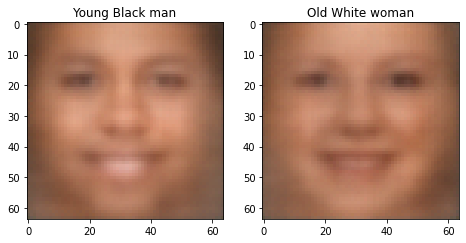

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  1 :  0.020179534050565894


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  2 :  0.020152486420126372


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  3 :  0.0201646594671152


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  4 :  0.02017458031574885


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  5 :  0.020150746409130352


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  6 :  0.020157101373839123


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  7 :  0.020166004497197368


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  8 :  0.020147472099270872


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  9 :  0.02015514161077238


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  10 :  0.02013973348964286


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  11 :  0.0201390618358248


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  12 :  0.020153070589707743


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  13 :  0.020132719629233884


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  14 :  0.020148548287569835


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  15 :  0.020125224325124935


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  16 :  0.02012837546006326


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  17 :  0.020117836593780466


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  18 :  0.020144418683103335


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  19 :  0.020120375699573947


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  20 :  0.020153870245301596


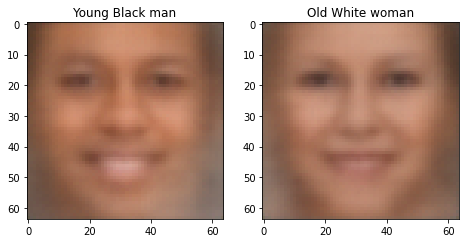

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  21 :  0.02011780134372173


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  22 :  0.02013808332623974


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  23 :  0.020126714741670958


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  24 :  0.020127702985079057


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  25 :  0.020111665790600163


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  26 :  0.020119138202199374


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  27 :  0.020108171488328646


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  28 :  0.02013653644951441


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  29 :  0.0201131051346179


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  30 :  0.02010080036056298


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  31 :  0.02010342857289699


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  32 :  0.02010958105005244


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  33 :  0.020128759926044813


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  34 :  0.020108339426818715


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  35 :  0.020109782956780925


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  36 :  0.02011436772763088


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  37 :  0.02011483567216063


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  38 :  0.020105980637092746


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  39 :  0.020133186952881917


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  40 :  0.020118411229823226


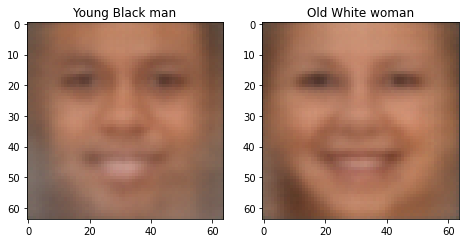

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  41 :  0.020097635225743374


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  42 :  0.020097782815335898


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  43 :  0.02009103747625505


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  44 :  0.02009854710070036


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  45 :  0.020094526911615042


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  46 :  0.020105477102020736


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  47 :  0.02010180793141806


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  48 :  0.02009495047311629


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  49 :  0.020104298287982582


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  50 :  0.020091998380839183


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  51 :  0.020106016968687374


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  52 :  0.020076002044382917


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  53 :  0.02007365467086915


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  54 :  0.020090469229285434


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  55 :  0.020078768673282798


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  56 :  0.02007409954263318


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  57 :  0.02008765843766992


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  58 :  0.02008331368767446


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  59 :  0.020090593946396663


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  60 :  0.020073860282859495


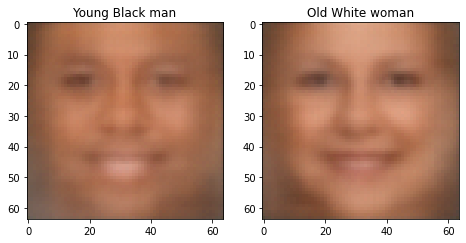

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  61 :  0.020087914381136177


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  62 :  0.020091636727253597


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  63 :  0.020084347235419416


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  64 :  0.020059872679011798


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  65 :  0.02007947018950857


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  66 :  0.02006917346709518


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  67 :  0.020101704304256746


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  68 :  0.020071518897850027


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  69 :  0.020091579185538395


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  70 :  0.0200680820371515


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  71 :  0.02005908582159268


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  72 :  0.02006902379454464


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  73 :  0.02007134827554867


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  74 :  0.02007698554105015


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  75 :  0.020051672193472102


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  76 :  0.02007048827425767


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  77 :  0.02006498860415592


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  78 :  0.020053357126251344


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  79 :  0.020052963947897316


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  80 :  0.020053861242148183


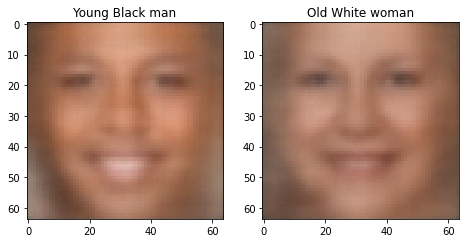

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  81 :  0.020076155221910887


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  82 :  0.020041413004359892


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  83 :  0.02009900709393845


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  84 :  0.020041348252405403


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  85 :  0.020050869453498113


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  86 :  0.020056924872821378


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  87 :  0.020043195195255742


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  88 :  0.020031800974280603


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  89 :  0.02003510450563764


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  90 :  0.020052139577205464


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  91 :  0.020037244324402143


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  92 :  0.020045280096031005


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  93 :  0.02006440866057591


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  94 :  0.02007631931494


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  95 :  0.02003386995244411


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  96 :  0.020026646674640717


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  97 :  0.020053660797495997


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  98 :  0.02004475066418289


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  99 :  0.020052400027071277


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  100 :  0.020053959241317164


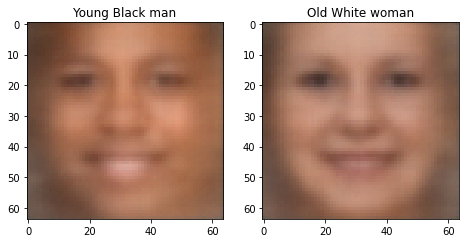

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  101 :  0.020042491315673757


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  102 :  0.020033167975564158


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  103 :  0.020033871494634176


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  104 :  0.020032867468813415


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  105 :  0.020044568765868423


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  106 :  0.02002647777478541


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  107 :  0.02003333116731336


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  108 :  0.020027490673206187


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  109 :  0.0200396774396781


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  110 :  0.020019167673683936


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  111 :  0.020043696427056865


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  112 :  0.020024971415599186


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  113 :  0.020038050148756273


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  114 :  0.020014364592811112


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  115 :  0.020018307151653432


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  116 :  0.020038135750319368


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  117 :  0.020028827571740713


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  118 :  0.02002135367803676


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  119 :  0.020014950224468784


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  120 :  0.02000449025022086


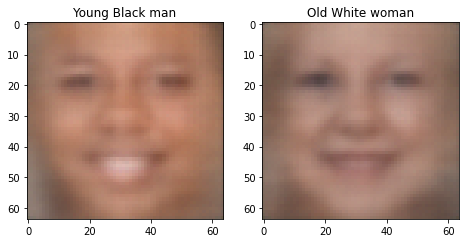

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  121 :  0.020009125632944928


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  122 :  0.02003149524010638


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  123 :  0.02000041546360139


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  124 :  0.020007912950810565


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  125 :  0.01999819635223317


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  126 :  0.02003361807475167


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  127 :  0.020001163766268763


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  128 :  0.02000742251433993


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  129 :  0.02002084183116113


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  130 :  0.02002093762720144


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  131 :  0.020018861839367498


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  132 :  0.019983495014809793


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  133 :  0.019996242137044987


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  134 :  0.02000504235426585


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  135 :  0.019999817654650698


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  136 :  0.02000647352667906


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  137 :  0.019991054229678645


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  138 :  0.020032190687714085


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  139 :  0.019998195450953257


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  140 :  0.020000343982090232


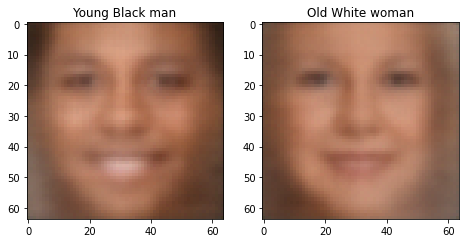

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  141 :  0.020002667261387712


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  142 :  0.020004969931417895


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  143 :  0.01998649405375604


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  144 :  0.019990260682759747


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  145 :  0.01998204423455141


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  146 :  0.01998161506508627


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  147 :  0.019987003857730536


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  148 :  0.019990002255766623


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  149 :  0.019984297214015838


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  150 :  0.020012719536660818


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  151 :  0.01999388092387748


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  152 :  0.020020408535836844


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  153 :  0.019978087996282885


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  154 :  0.0200012588212567


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  155 :  0.019971439394579137


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  156 :  0.01998681276636098


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  157 :  0.019981334426550455


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  158 :  0.01994888372318719


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  159 :  0.019958112509019913


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  160 :  0.019984572064331782


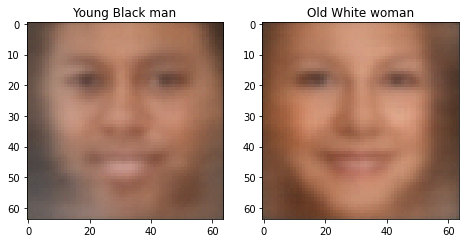

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  161 :  0.01995419420462142


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  162 :  0.020006925007829104


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  163 :  0.01999393600209426


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  164 :  0.019972399157542054


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  165 :  0.0199563263725209


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  166 :  0.019962815007054678


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  167 :  0.019950482333379406


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  168 :  0.019970943270030843


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  169 :  0.020000907342119883


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  170 :  0.0199724638894681


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  171 :  0.019989499241434117


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  172 :  0.019956340252231527


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  173 :  0.0199577805576145


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  174 :  0.01996911849866631


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  175 :  0.019937084066451238


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  176 :  0.01996771095981521


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  177 :  0.0199366009403621


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  178 :  0.019978462768498288


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  179 :  0.01994499155590611


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  180 :  0.01993725735253544


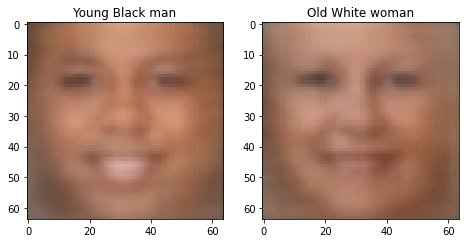

  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  181 :  0.019961938882867496


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  182 :  0.019960234602612835


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  183 :  0.01993605212098168


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  184 :  0.01995913289807817


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  185 :  0.019945479849333404


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  186 :  0.019949734331138672


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  187 :  0.01995249182706879


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  188 :  0.01995032595130064


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  189 :  0.019943987610199117


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  190 :  0.019942520046105947


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  191 :  0.019967348825547


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  192 :  0.019954712520683964


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  193 :  0.01993907545442863


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  194 :  0.01992326149696945


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  195 :  0.019939570557526362


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  196 :  0.01994648195242369


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  197 :  0.01992537904410593


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  198 :  0.01994236226203621


  0%|          | 0/93 [00:00<?, ?it/s]

Mean loss for epoch  199 :  0.019918086988631116


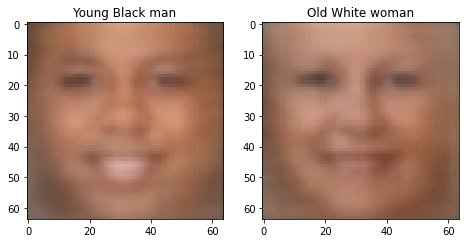

In [ ]:
print("Example generated images:")
f, axarr = plt.subplots(1,2)
axarr[0].set_title("Young Black man")
axarr[1].set_title("Old White woman")
f.subplots_adjust(hspace=0.3,left=2,right=3) 
# array to store loss for every epoch
error_count = 0
losstrack = []
for i in tqdm(range(epochs)):
    losses = []
    for j in tqdm(range(ceil(n_samples, better_batch_size))):
        # get batch
        #if j == 38 or j == 39:
        #  continue
        batch = npData[j * better_batch_size: (j + 1) * better_batch_size]
        
        # getting attributes (skip first column, that's the image location)
        # print(batch[:, 1:])
        attrs = torch.Tensor(batch[:, 1:].astype('float16')).to(device)
        
        # getting images (not np array)
        imgs = faces[j * better_batch_size: (j + 1) * better_batch_size]
        imgs = torch.Tensor(imgs.astype('float16')).to(device)
        
        vae.zero_grad()

        #print(attrs)
        recon_imgs, mu, logvar = vae(imgs, attrs)
        
        #print("Imgs: ", imgs)
        #print("Attrs: ", attrs)

        #recon_imgs, mu, logvar = vae(imgs, attrs)


        err = loss(recon_imgs, imgs, mu, logvar)
        
        err.backward() 
        optimizer.step()
        
        # add loss to array for each image
        losses.append(err.item())
    
    # add mean loss for entire epoch
    losstrack.append(np.mean(losses))
    
    # print mean loss
    print("Mean loss for epoch ", i, ": ", np.mean(losses))

    # save model file every 50 epochs
    if i % 50 == 0:
      torch.save(vae.state_dict(), "drive/My Drive/ASDRP/Model Checkpoints/allimgs_checkpoint.pt")

    # showing generated images to see progress
    if i % 20 == 0:
      axarr[0].imshow(showImage([[2, 0, 1]]))
      axarr[1].imshow(showImage([[6, 1, 0]]))  

      display(plt.gcf())
      #clear_output(wait = True)
      time.sleep(0.5)

# Generating images

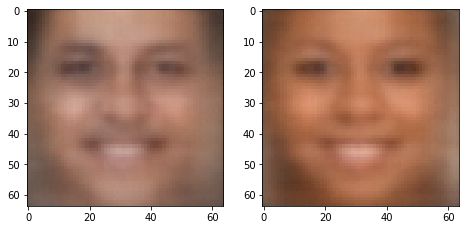

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(showImage([[2, 0, 3]])) # young black male
#axarr[0].set_title("Woman")
axarr[1].imshow(showImage([[2, 1, 1]])) # white female
#axarr[1].set_title("Man")

f.subplots_adjust(hspace=0.3,left=2,right=3)

In [ ]:
!pip install imagehash
import imagehash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 812 kB 5.1 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=71337f06e0f32f42dbe28203476a09beaef29fa0c5e7ed877da11f269ee4aa73
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built imagehash


In [ ]:
import random

In [ ]:
import matplotlib

In [ ]:
'''
for i in tqdm(range(5)):
  gender = random.randint(0, 1)
  age = random.randint(0, 9)
  race = 3
  indices = np.asarray(np.where((df['gender'] == gender) & (df['age'] == age) & (df['race'] == race)))

  attempts = 0
  while not np.any(indices) and attempts < 5:
    gender = random.randint(0, 1)
    age = random.randint(0, 9)  
    indices = np.asarray(np.where((df['gender'] == gender) & (df['age'] == age) & (df['race'] == race)))
    attempts += 1
  
  if not np.any(indices):
    print("No indices found")
    break
  
  index = random.choice(random.choice(indices))
  hash1 = imagehash.average_hash(Image.open(df.iloc[index]['image']))

  best_similarity = 100
  best_pic = None
  for i in range(50):
    pic = showImage([[age, gender, race]])
    hash2 = imagehash.average_hash(Image.fromarray(np.reshape(pic, (96, 128))))

    if (hash1 - hash2) < best_similarity:
      best_similarity = hash1 - hash2
      best_pic = pic
  
  print("Best similarity found: ", best_similarity)

  location = 'drive/My Drive/ASDRP/generated_images/' + str(age) + '_' + str(gender) + '_' + str(race)
  count = 0
  for file in os.listdir('drive/My Drive/ASDRP/generated_images/'):
    if file.startswith(str(age) + '_' + str(gender) + '_' + str(race)):
      count += 1
    
  location += '_' + str(count)

  matplotlib.image.imsave(location + '.png', best_pic)
'''


  0%|          | 0/5 [00:00<?, ?it/s]

Best similarity found:  34
Best similarity found:  31
Best similarity found:  33
Best similarity found:  37
Best similarity found:  35


In [ ]:
df['race'].value_counts()

0    10078
1     4526
Name: race, dtype: int64

In [ ]:
import cv2
from cv2 import dnn_superres

# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

# Read the desired model
path = "EDSR_x2.pb"
sr.readModel(path)

sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("edsr", 2)

In [ ]:
'''
for i in tqdm(range(100)):
  gender = random.randint(0, 1)
  race = 1

  img_array = showImage([[gender, race]])

  location = 'drive/My Drive/ASDRP/generated_images/' + str(gender) + '_' + str(race)
  count = 0
  for file in os.listdir('drive/My Drive/ASDRP/generated_images/'):
    if file.startswith(str(gender) + '_' + str(race)):
      count += 1
    
  location += '_' + str(count)

  try:
    matplotlib.image.imsave('original.png', img_array)
  except:
    #matplotlib.image.imsave('original.png', tf.clip_by_value(img_array, 0.0, 1.0))
    print(location + '_' + str(count))

  image = cv2.imread('original.png')
  #image = Image.fromarray(img_array, 'RGB')
  #image = np.array(img)
  #image = cv2.imread(ocvim)
  scale_percent = 156.25 # percent of original size
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  result = sr.upsample(resized)
  
  cv2.imwrite(location + '.png', result)

'''


  


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df['age'].value_counts()

3    7344
4    4536
6    2299
5    2245
0    1605
2    1531
1    1457
8    1372
7    1316
Name: age, dtype: int64

In [ ]:
for i in tqdm(range(1140)):
  gender = random.randint(0, 1)
  race = 4
  age = random.randint(0, 5)

  img_array = showImage([[age, gender, race]])

  location = 'drive/My Drive/ASDRP/generated_images/' + str(age) + '_' + str(gender) + '_' + str(race)
  count = 0

  for file in os.listdir('drive/My Drive/ASDRP/generated_images/'):
    if file.startswith(str(age) + '_' + str(gender) + '_' + str(race)):
      count += 1
    
  location += '_' + str(count)

  try:
    matplotlib.image.imsave(location + '.png', img_array)
  except:
    print("Didn't work")
    continue





  


  0%|          | 0/1140 [00:00<?, ?it/s]

In [ ]:
# 2140
get_file_count('drive/My Drive/ASDRP/generated_images')

  0%|          | 0/8410 [00:00<?, ?it/s]

8410

In [ ]:
df_unbalanced = pd.read_csv('drive/My Drive/ASDRP/Experiments/simple-cnn-v3/df.csv')

In [ ]:
df_unbalanced['race'].value_counts()

0    2682
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [ ]:
df_generated = pd.DataFrame()

In [ ]:
# adding generated images to df
for image in tqdm(os.listdir('drive/My Drive/ASDRP/generated_images')):
    image_path = os.path.join('drive/My Drive/ASDRP/generated_images', image)
    vals = image.split('_')
    age = int(vals[0])
    gender = int(vals[1])
    race = int(vals[2])

    row_to_add = {'image': image_path, 'age': age, 'gender': gender, 'race': race}
    df_generated = df_generated.append(row_to_add, ignore_index = True)
    

  0%|          | 0/8410 [00:00<?, ?it/s]

In [ ]:
df_generated.age = df_generated.age.astype(int)
df_generated.race = df_generated.race.astype(int)
df_generated.gender = df_generated.gender.astype(int)

In [ ]:
df_generated.head()

,image,age,gender,race
0,drive/My Drive/ASDRP/generated_images/0_0_1_0.png,0,0,1
1,drive/My Drive/ASDRP/generated_images/0_1_1_0.png,0,1,1
2,drive/My Drive/ASDRP/generated_images/2_1_1_0.png,2,1,1
3,drive/My Drive/ASDRP/generated_images/2_0_1_0.png,2,0,1
4,drive/My Drive/ASDRP/generated_images/1_1_1_0.png,1,1,1


In [ ]:
# rows = df.loc[df['image'].astype(str).str.endswith('.png')]

In [ ]:
df_generated.to_csv(r'drive/My Drive/ASDRP/Experiments/gender-with-fakes/df_generated_only.csv', index = False, header=True)